Тест аугментации

# Initialization

### Params

In [1]:
params = {
'seed' : 241075,
'model' : 'FNN',
'backbone' : 'resnet34',
'initial_weightns' : 'imagenet',
'optimizer' : 'adam',
'augmented_image_size' : 101,
'padded_image_size' : 128,
'nn_image_size' : 96,
'channels' : 3,
'coord_conv' : False, # default False. CoordinatesConv layers (R and B channels)
'norm_sigma_k' : 1.,

'load_model_from' : None, #'models_1/FNN_resnet34_adam_960x544_f1_9e2580.model',
    
'train_augmentation_mode': 'basic',
'test_augmentation_mode': 'basic',
    
'epochs_warmup' : 2,
'epochs' : 250,
'batch_size' : 20,
'test_batch_size' : 50,

'monitor_metric' : ('val_my_iou_metric','max'), # default 'val_my_iou_metric'
    
'ReduceLROnPlateau' : {
        'factor' : 0.5,
        'patience' : 10,
        'min_lr' : 1e-6,
    },
'EarlyStopping' : {'patience': 50},

'test_fold_no' : 1,

'attempt' : 0,
'comment' : '',
}
params = type("params", (object,), params)

In [2]:
def params_dict():
    return {x[0]:x[1] for x in vars(params).items() if not x[0].startswith('__')}
def params_str():
    return '\n'.join([repr(x[0]) + ' : ' + repr(x[1]) + ',' for x in vars(params).items() if not x[0].startswith('__')])
def params_hash(shrink_to = 6):
    import hashlib
    import json
    return hashlib.sha1(json.dumps(params_dict(), sort_keys=True).encode()).hexdigest()[:shrink_to]
def params_save(fn, verbose = True):
    params_fn = fn+'.param'
    with open(params_fn, 'w+') as f:
        s = params_str()
        s = '{\n' + s + '\n}\nhash: ' + params_hash(shrink_to = 1000)
        f.write(s)
        if verbose:
            print('perams: '+ s + ' saved to ' + params_fn)
        

### Imports

In [3]:
import sys
from imp import reload
import numpy as np
import keras

from keras.models import Model, load_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras import backend as K

import tensorflow as tf

c:\miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import os
import glob
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
%matplotlib inline

In [5]:
import local_config

In [6]:
img_folder = local_config.basicpath

### Reproducability setup:

In [7]:
import random as rn

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(params.seed)
rn.seed(params.seed)

#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
tf.set_random_seed(params.seed)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
sess = tf.Session(graph=tf.get_default_graph())
K.set_session(sess)

# Load data

In [8]:
DEV_MODE_RANGE = None

In [9]:
import load_data
load_data = reload(load_data)
import keras_unet_divrikwicky_model
keras_unet_divrikwicky_model = reload(keras_unet_divrikwicky_model)

train_df = load_data.LoadData(train_data = True, DEV_MODE_RANGE = DEV_MODE_RANGE, to_gray = False)
train_df.images[0].shape

(3920, 9) (18000, 1) (22000, 1)


HBox(children=(IntProgress(value=0, max=3920), HTML(value='')))

HBox(children=(IntProgress(value=0, max=3920), HTML(value='')))

(101, 101, 3)

In [10]:
train_images, train_masks, validate_images, validate_masks = load_data.SplitTrainData(train_df, params.test_fold_no)

In [11]:
train_images.shape, train_masks.shape, validate_images.shape, validate_masks.shape

((3136,), (3136,), (784,), (784,))

In [12]:
train_images[0].shape, train_images[0].dtype, np.max(train_images[0]), train_masks[0].shape, len(train_images), len(validate_images)

((101, 101, 3), dtype('float32'), 1.0, (101, 101), 3136, 784)

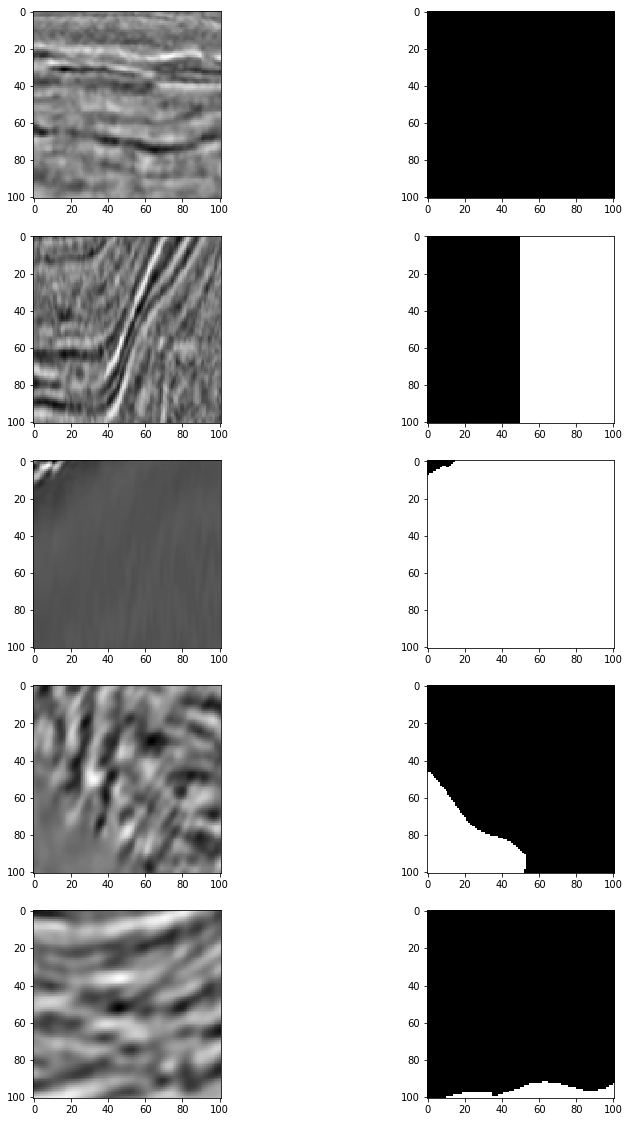

In [13]:
n = 5
plt.figure(figsize=(20,4*n))
for i in range(5):
    plt.subplot(n, 3, 3*i+1)
    imshow(train_images[i])
    plt.subplot(n, 3, 3*i+2)
    imshow(train_masks[i], cmap='gray')

# Data generator

In [14]:
mean_val, mean_std = (0.481577, 0.11108)

In [15]:
del AlbuDataGenerator

NameError: name 'AlbuDataGenerator' is not defined

In [16]:
from my_augs import AlbuDataGenerator

# test aug

In [17]:
    train_gen = AlbuDataGenerator(train_images, train_masks, batch_size=20, nn_image_size = params.nn_image_size,
                                  mode = params.train_augmentation_mode, shuffle=False, params = params, mean=(mean_val, mean_std))

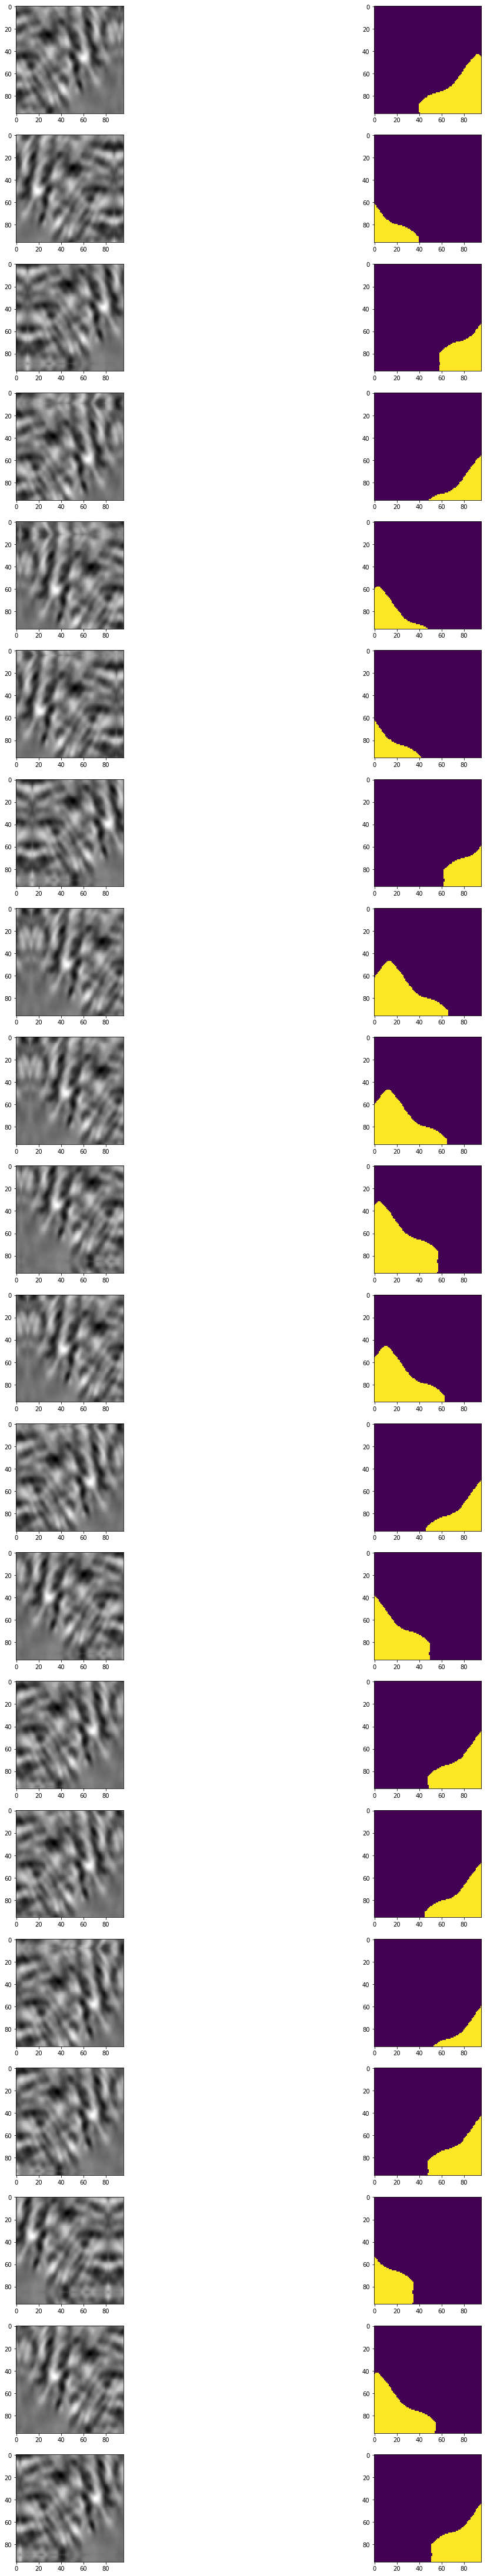

In [18]:
n = 20
img_no = 3
plt.figure(figsize=(20,4*n))
for i in range(n):
    img_i = train_gen[0]
    img = np.clip(img_i[0][img_no]*mean_std + mean_val,0,1)
    mask = img_i[1][img_no]
    #print(i, img.dtype, img.shape, np.min(img), np.max(img), mask.dtype, mask.shape, np.min(mask), np.max(mask))
    plt.subplot(n, 2, 2*i+1)
    imshow(img)
    plt.subplot(n, 2, 2*i+2)
    imshow(mask.reshape(mask.shape[:-1]))# , cmap='gray'


In [ ]:
image_names[0]